## Filter out guides that are multi-targeting

Run this script after: `align_guides.R`

**Input:**  
- Guide alignment file computed in `align_guides.R`
- Guide level log-fold changes file downloaded from DepMap
- List of dropped guides from DepMap portal
- HGNC gene ID map

**Output:**  
- Filtered version of the log-fold changes file

Notes: 
- From 19Q3 DepMap does alignment to GRCh38, this is mentioned in Tsherniak et al (2019) https://www.biorxiv.org/content/10.1101/720243v1.full
- Guides that have > 100 alignments are not used by CERES.  
- Definitions of "PAM-distal" are taken from Fortin et al (2019): https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1621-7

In [225]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import os
import re
from random import randint
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update({'font.size': 10, 'axes.spines.top': False, 'axes.spines.right': False})

get_data_path = lambda folders, fname: os.path.normpath(os.environ['3RD_PARTY_DIR']+'/'+'/'.join(folders) +'/'+ fname)
get_local_data_path = lambda folders, fname: os.path.normpath('../local_data/' +'/'.join(folders) +'/'+ fname)

perfect_alignment = 20

# Input from DepMap
file_logfold_changes = get_data_path(['depmap', '20Q2'], 'Achilles_logfold_change.csv')
file_guide_map = get_data_path(['depmap', '20Q2'], 'Achilles_guide_map.csv')
file_dropped_guides = get_data_path(['depmap', '20Q2'], 'Achilles_dropped_guides.csv')

# Input from R script
file_alignments = get_local_data_path(['processed', 'depmap20Q2'], 'guide_alignments_hg38.csv')

# Input from 1_data_processing
file_id_map = get_local_data_path(['processed'], 'HGNC_gene_id_map.csv')

# OUTPUT
file_filtered_lfc = get_local_data_path(['processed', 'depmap20Q2'], 'filtered_lfc_26_05_20.csv')
file_guides_per_gene = get_local_data_path(['processed', 'depmap20Q2'], 'guides_per_gene_26_05_20.csv')

### Load alignments computed in R script + DepMap guide map

In [226]:
# Load and clean the alignment file generated in R notebook
raw_alignments = pd.read_csv(file_alignments)
display(raw_alignments[:1])

,sgrna,chr,cut_pos,strand,alignment,gene,geneID,CDS_strand,CDS_start,CDS_end
0,AAAAAAATCCAGCAATGCAG,chr10,110964620,+,20,SHOC2,8036,+,110964358,110965060


In [227]:
# Duplicates: different CDS_start and CDS_end (multiple exons) - but only considering gene level
alignments = raw_alignments.drop_duplicates(subset=['sgrna', 'gene', 'geneID', 'alignment'])
alignments = alignments.rename(columns={'geneID':'entrez_id'})
alignments = alignments[['sgrna', 'alignment', 'entrez_id', 'gene', 'chr', 'strand', 'cut_pos']]
alignments = alignments.sort_values('gene')

print('# of guides:', alignments.sgrna.nunique())

# Check there is no alignment to X and Y chromosomes
assert(alignments[(alignments.chr == 'chrX') | (alignments.chr == 'chrY')].shape[0] == 0)
alignments[:1]

# of guides: 70509


,sgrna,alignment,entrez_id,gene,chr,strand,cut_pos
83854,GTGTGCCGAGGTGTGCTGCG,20,1,A1BG,chr19,-,58352467


In [189]:
# Load DepMap guide map - this would only include perfect alignments
# From DepMap portal: n_alignments (integer number of perfect matches for that guide)
depmap_guide_map = pd.read_csv(file_guide_map)
assert(depmap_guide_map[depmap_guide_map.gene.isna()].shape[0]==0)

# Extract Entrez ID and symbol
get_gene_id = lambda x: int(re.search('[\w-]+\s\((\w+)\)', x).group(1))
get_gene_symbol = lambda x: re.search('([\w-]+)\s\(\w+\)', x).group(1)
depmap_guide_map['symbol'] = depmap_guide_map.gene.apply(get_gene_symbol)
depmap_guide_map['entrez_id'] = depmap_guide_map.gene.apply(get_gene_id)

# Exclude X/Y chr genes - I didn't align to those
depmap_guide_map = depmap_guide_map[~depmap_guide_map.genome_alignment.str.startswith('chrX') & 
                                    ~depmap_guide_map.genome_alignment.str.startswith('chrY')]

# Add locus type info
id_map = pd.read_csv(file_id_map, index_col=0)[['locus_type','entrez_id']]
id_map = id_map.dropna(subset=['entrez_id']).astype({'entrez_id':'int'})
depmap_guide_map = pd.merge(depmap_guide_map, id_map, how='left')

print('# of guides:', depmap_guide_map.sgrna.nunique())
depmap_guide_map[:1]

# of guides: 69259


,sgrna,genome_alignment,gene,n_alignments,symbol,entrez_id,locus_type
0,AAAAAAATCCAGCAATGCAG,chr10_110964620_+,SHOC2 (8036),1,SHOC2,8036,gene with protein product


### 1. Determine alignment types
Drop alignments for guides w/ 0 perfect matches.  
Drop non-PAM-distal double mismatch alignments (don't consider these).

In [190]:
# Calculate alignment type based on the 'alignment' encoding 
# PAM-distal = in the 10 nucleotides furthest from the PAM for single mismatch
# PAM-distal = in the 2 nucleotides furthest from the PAM for double mismatch
def get_alignment_type(row):
    if row.alignment == str(perfect_alignment):
        return 'perfect'
    match = re.search('^(\d+)[ATCG]\d+$', row.alignment)
    if match != None:
        if ((row.strand == '+' and int(match.group(1)) <= 9) or 
            (row.strand == '-' and int(match.group(1)) >= (perfect_alignment-9))):
            return 'pam_distal_single'
        return 'single'
    match = re.search('^(\d+)[ATCG](\d+)[ATCG](\d+)$', row.alignment)
    if match != None:
        if ((row.strand == '+' and int(match.group(3)) == (perfect_alignment-2)) or 
            (row.strand == '-' and int(match.group(1)) == (perfect_alignment-2))):
            return 'pam_distal_double'
        return 'double'
    
alignments_1 = alignments.assign(align_type = alignments.apply(get_alignment_type, axis=1))

In [191]:
print('# of guides mapped:', alignments_1.sgrna.nunique())
alignments_1[:2]

# of guides mapped: 70509


,sgrna,alignment,entrez_id,gene,chr,strand,cut_pos,align_type
83854,GTGTGCCGAGGTGTGCTGCG,20,1,A1BG,chr19,-,58352467,perfect
68259,GGAAGTCTGGAGTCTCCAGG,20,1,A1BG,chr19,+,58353109,perfect


### 2. Drop guides that were dropped by DepMap

Num guides dropped in DepMap: 2554
Num guides to drop here: 1006
# of guides mapped: 69503
N guides to drop so far: 1006


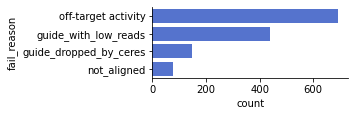

In [192]:
# Look at guides that were dropped in Depmap analysis
depmap_dropped_guides = pd.read_csv(file_dropped_guides)
depmap_dropped_guides = depmap_dropped_guides.rename(columns={'Unnamed: 0':'sgrna'})
print('Num guides dropped in DepMap:', depmap_dropped_guides.sgrna.nunique())
print('Num guides to drop here:', alignments_1[alignments_1.sgrna.isin(depmap_dropped_guides.sgrna)].sgrna.nunique())

# Reasons for dropped guides, 'in_dropped_guides' => suspected off-target activity
f, ax = plt.subplots(1, 1, figsize=(3.5,1.3))
df = depmap_dropped_guides[depmap_dropped_guides.sgrna.isin(raw_alignments.sgrna)]
df = df.assign(fail_reason = df.fail_reason.apply(lambda x: 'off-target activity' if x=='in_dropped_guides' else x))
_=sns.countplot(data=df, y='fail_reason', ax=ax, color='royalblue', order=df['fail_reason'].value_counts().index)

# Drop guides that were dropped in Depmap analysis
alignments_2 = alignments_1[~alignments_1.sgrna.isin(depmap_dropped_guides.sgrna)].reset_index(drop=True)
alignments_2 = alignments_2.rename(columns={'gene':'symbol'})
print('# of guides mapped:', alignments_2.sgrna.nunique())

# Track guides to drop
guides_to_drop = pd.Series(depmap_dropped_guides[depmap_dropped_guides.sgrna.isin(alignments_1.sgrna)].sgrna.unique())
print('N guides to drop so far:', guides_to_drop.shape[0])

In [193]:
# Check that sgRNAs are the same in this map and depmap guide map
print('Guides w/ perfect alignment in this map but not in DepMap map:', 
      alignments_2[(alignments_2.align_type=='perfect') & ~alignments_2.sgrna.isin(depmap_guide_map.sgrna)].shape[0])
print('Guides in DepMap map not in this map:', depmap_guide_map[~depmap_guide_map.sgrna.isin(alignments_2.sgrna)].shape[0])

Guides w/ perfect alignment in this map but not in DepMap map: 0
Guides in DepMap map not in this map: 0


In [194]:
# Check that sgRNA mappings in depmap guide map are all in this map
df = pd.merge(depmap_guide_map[['sgrna','entrez_id','gene']], 
              alignments_2[['sgrna','entrez_id','symbol','align_type']], on=['sgrna','entrez_id'], how='outer')
print('Mappings missing from my map:')
df[df.symbol.isna()]

Mappings missing from my map:


,sgrna,entrez_id,gene,symbol,align_type


### 3. Add locus type for each gene and drop guides that target readthrough genes

,sgrna,alignment,entrez_id,symbol,chr,strand,cut_pos,align_type,locus_type
0,GTGTGCCGAGGTGTGCTGCG,20,1,A1BG,chr19,-,58352467,perfect,gene with protein product


Num guides aligned to 1+ readthrough genes: 374
# of guides mapped: 68931
N guides to drop so far: 1380


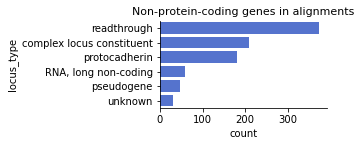

In [195]:
# Add locus info, e.g. read-through gene
id_map = pd.read_csv(file_id_map, index_col=0)[['locus_type','entrez_id']]
id_map = id_map.dropna(subset=['entrez_id']).astype({'entrez_id':'int'})
alignments_3 = pd.merge(alignments_2, id_map, how='left')

# Don't consider guides that map through non-PAM-distal double mismatch
alignments_3 = alignments_3[(alignments_3.align_type != 'double')]

# Extra genes to mark as read-through
genes_to_mark_as_readthrough = ['LOC110117498-PIK3R3', 'LY6G6F-LY6G6D', 'PALM2-AKAP2']
alignments_3.loc[alignments_3.symbol.isin(genes_to_mark_as_readthrough), 'locus_type'] = 'readthrough'

# Look at genes that are not classified as "gene with protein product"
f, ax = plt.subplots(1, 1, figsize=(3,1.6))
df = alignments_3[alignments_3.locus_type!='gene with protein product']
_=sns.countplot(data=df, y='locus_type', ax=ax, color='royalblue', order=df['locus_type'].value_counts().index)
ax.set_title('Non-protein-coding genes in alignments', fontsize=11)
display(alignments_3[:1])

# Drop all guides targeting readthrough genes
readthrough_guides = alignments_3[alignments_3.locus_type=='readthrough'].sgrna.unique()
print('Num guides aligned to 1+ readthrough genes:', len(readthrough_guides))
alignments_3 = alignments_3[~alignments_3.sgrna.isin(readthrough_guides)].reset_index(drop=True)
assert(alignments_3[alignments_3.locus_type=='readthrough'].shape[0]==0)
print('# of guides mapped:', alignments_3.sgrna.nunique())

# Track guides to drop
guides_to_drop = pd.concat([guides_to_drop, pd.Series(readthrough_guides)]).drop_duplicates()
print('N guides to drop so far:', guides_to_drop.shape[0])

### 4. Count number of alignments per guide (incl. w/ mismatch)
Only consider alignments to protein-coding genes

In [215]:
# Drop alignments to non-protein-coding genes - don't want to consider these when counting num alignments
guide_map = alignments_3[alignments_3.locus_type=='gene with protein product'].reset_index(drop=True)
guide_map = guide_map.drop(columns=['locus_type'])

# Annotate guides with number of genes they align to
# Only count 1 alignment per sgrna-gene pairs - guide could match to gene at multiple loci
num_alns = guide_map.groupby('sgrna').entrez_id.nunique().reset_index().rename(columns={'entrez_id':'n_aln'})
guide_map = pd.merge(guide_map, num_alns)
guide_map[:2]

,sgrna,alignment,entrez_id,symbol,chr,strand,cut_pos,align_type,n_aln
0,GTGTGCCGAGGTGTGCTGCG,20,1,A1BG,chr19,-,58352467,perfect,1
1,GGAAGTCTGGAGTCTCCAGG,20,1,A1BG,chr19,+,58353109,perfect,1


In [216]:
# Check where DepMap counts more alignments than my map
# Add manual alignment counts because there are cases where e.g. only 1 alignments is listed but n_alignments=2
depmap_coding_guide_map = depmap_guide_map[depmap_guide_map.locus_type=='gene with protein product']
sgrna_count = depmap_coding_guide_map.groupby('sgrna').gene.nunique().reset_index().rename(columns={'gene':'n_aln_in_table'})
depmap_coding_guide_map = pd.merge(depmap_coding_guide_map, sgrna_count)
df = pd.merge(depmap_coding_guide_map, guide_map[['sgrna','n_aln']], on=['sgrna']).drop_duplicates()
df[df.n_aln_in_table > df.n_aln]

,sgrna,genome_alignment,gene,n_alignments,symbol,entrez_id,locus_type,n_aln_in_table,n_aln


In [217]:
guide_map[guide_map.sgrna.isin(
    guide_map[(guide_map.symbol=='UBC') & (guide_map.align_type=='perfect')].sgrna)].sort_values('sgrna')

,sgrna,alignment,entrez_id,symbol,chr,strand,cut_pos,align_type,n_aln
68936,GCAAAGATCCAGGACAAGGA,8T11,7316,UBC,chr12,-,124912077,single,1
68937,GCAAAGATCCAGGACAAGGA,20,7316,UBC,chr12,-,124913445,perfect,1
68929,GCATCCCTCCTGACCAGCAG,10C9,7314,UBB,chr17,+,16382255,single,2
68930,GCATCCCTCCTGACCAGCAG,20,7316,UBC,chr12,-,124912511,perfect,2
68931,GCATCCCTCCTGACCAGCAG,6A13,7316,UBC,chr12,-,124911827,single,2
68932,GCATCCCTCCTGACCAGCAG,15A4,7316,UBC,chr12,-,124912967,pam_distal_single,2
68933,GCATTCCTCCTGACCAGCAG,6A13,7316,UBC,chr12,-,124913195,single,1
68934,GCATTCCTCCTGACCAGCAG,20,7316,UBC,chr12,-,124913423,perfect,1
68935,GCATTCCTCCTGACCAGCAG,15G4,7316,UBC,chr12,-,124913651,pam_distal_single,1


### 5. Filter out multi-targeting guides

In [222]:
# Filter out guides that align to more than one coding gene
guides_w_multiple_matches = guide_map[guide_map.n_aln > 1]
unique_alignments = guide_map[~guide_map.sgrna.isin(guides_w_multiple_matches.sgrna)]

dropped_guides = raw_alignments[~raw_alignments.sgrna.isin(unique_alignments.sgrna)].sgrna.unique()
print('N dropped guides:', len(dropped_guides))

# For final alignment map only count perfect alignments
unique_alignments = unique_alignments[unique_alignments.align_type=='perfect'].reset_index(drop=True)
print('Multi-targeting guides:', guides_w_multiple_matches[guides_w_multiple_matches.align_type=='perfect'].sgrna.nunique())

unique_alignments[:2]

N dropped guides: 5205
Multi-targeting guides: 3251


,sgrna,alignment,entrez_id,symbol,chr,strand,cut_pos,align_type,n_aln
0,GTGTGCCGAGGTGTGCTGCG,20,1,A1BG,chr19,-,58352467,perfect,1
1,GGAAGTCTGGAGTCTCCAGG,20,1,A1BG,chr19,+,58353109,perfect,1


### Count guides per gene after filtering

In [223]:
# Save out guides per gene to use in CERES post-processing
assert(unique_alignments[unique_alignments.align_type!='perfect'].shape[0] == 0)
guides_per_gene = unique_alignments.groupby(['symbol', 'entrez_id']).sgrna.nunique().reset_index()
guides_per_gene = guides_per_gene.rename(columns={'sgrna':'guides_per_gene'})
guides_per_gene.to_csv(file_guides_per_gene)
print('Map size:', guides_per_gene.shape[0])
guides_per_gene[:2]

Map size: 17047


,symbol,entrez_id,guides_per_gene
0,A1BG,1,4
1,A1CF,29974,4


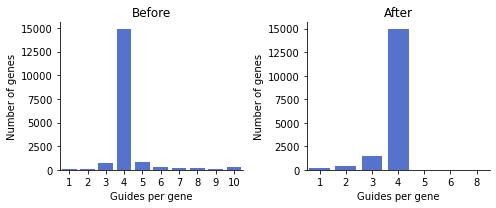

In [224]:
# Guides per gene before and after filtering
def plot_guides_per_gene(guide_map, ax):
    guides_per_gene = pd.DataFrame(guide_map.groupby('entrez_id').sgrna.nunique())
    guides_per_gene = guides_per_gene.assign(counts = guides_per_gene.sgrna.apply(lambda x: 10 if x>=10 else x))
    sns.countplot(guides_per_gene.counts, ax=ax, color='royalblue')
    ax.set_xlabel('Guides per gene'); ax.set_ylabel('Number of genes')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,3))
plot_guides_per_gene(guide_map, ax1)
plot_guides_per_gene(unique_alignments, ax2)
ax1.set_title('Before'); ax2.set_title('After'); plt.tight_layout()

### Filter original log-fold change file
This is the post-QC LFC

In [23]:
orig_lfc = pd.read_csv(file_logfold_changes, index_col=0)

In [204]:
print("N orig LFC:", orig_lfc.shape[0])
orig_lfc[:1]

N orig LFC: 74687


,143B-311Cas9_RepA_p6_batch3,2313287-311Cas9_RepA_p5_batch3,2313287-311Cas9_RepB_p5_batch3,253J-311Cas9_RepA_p5_batch3,42-MG-BA-311Cas9_RepA_p6_batch3,42-MG-BA-311Cas9_RepB_p6_batch3,5637-311Cas9_RepA_p6_batch3,5637-311Cas9_RepB_p6_batch3,59M-311Cas9_RepA_p4_batch3,59M-311Cas9_RepB_p4_batch3,...,YD8-311Cas9_RepA_p6_batch3,YD8-311Cas9_RepB_p6_batch3,YH-13-311Cas9_RepA_p6_batch3,YH-13-311Cas9_RepB_p6_batch3,YKG1-311Cas9_RepA_p6_batch3,YKG1-311Cas9_RepB_p6_batch3,YSCCC-311cas9-RepA-p6_batch3,YSCCC-311cas9-RepB-p6_batch3,ZR-75-1-311Cas9_RepA_p5_batch2,ZR-75-1-311Cas9_RepB_p5_batch2
Construct Barcode,,,,,,,,,,,,,,,,,,,,,
AAAAAAATCCAGCAATGCAG,0.289694,0.171917,-0.522717,-0.21169,-1.067942,-0.432573,-0.57371,0.012167,0.371828,-0.460308,...,-0.932634,-0.42067,-0.483853,-0.00565,-0.080897,-0.144761,-0.215475,-0.161553,-0.963836,-0.256333


In [213]:
filtered_lfc = orig_lfc[~orig_lfc.index.isin(dropped_guides)]
print('Filtered lfc:', filtered_lfc.shape[0])
display(filtered_lfc[:1])

Filtered lfc: 69482


,143B-311Cas9_RepA_p6_batch3,2313287-311Cas9_RepA_p5_batch3,2313287-311Cas9_RepB_p5_batch3,253J-311Cas9_RepA_p5_batch3,42-MG-BA-311Cas9_RepA_p6_batch3,42-MG-BA-311Cas9_RepB_p6_batch3,5637-311Cas9_RepA_p6_batch3,5637-311Cas9_RepB_p6_batch3,59M-311Cas9_RepA_p4_batch3,59M-311Cas9_RepB_p4_batch3,...,YD8-311Cas9_RepA_p6_batch3,YD8-311Cas9_RepB_p6_batch3,YH-13-311Cas9_RepA_p6_batch3,YH-13-311Cas9_RepB_p6_batch3,YKG1-311Cas9_RepA_p6_batch3,YKG1-311Cas9_RepB_p6_batch3,YSCCC-311cas9-RepA-p6_batch3,YSCCC-311cas9-RepB-p6_batch3,ZR-75-1-311Cas9_RepA_p5_batch2,ZR-75-1-311Cas9_RepB_p5_batch2
Construct Barcode,,,,,,,,,,,,,,,,,,,,,
AAAAAAATCCAGCAATGCAG,0.289694,0.171917,-0.522717,-0.21169,-1.067942,-0.432573,-0.57371,0.012167,0.371828,-0.460308,...,-0.932634,-0.42067,-0.483853,-0.00565,-0.080897,-0.144761,-0.215475,-0.161553,-0.963836,-0.256333


In [214]:
filtered_lfc.to_csv(file_filtered_lfc)